In [1]:
import numpy as np
import arviz as az
# import pymc3 as pm
import pickle
import matplotlib.pyplot as plt
from google.protobuf import text_format
from scipy.stats import multivariate_normal as mvn
from scipy.stats import skewnorm
from scipy.stats import norm
from scipy.interpolate import griddata
from pp_mix.interface import estimate_density_seq
import pp_mix.protos.py.params_pb2 as params_pb2

from pp_mix.interface import ConditionalMCMC, estimate_density_seq
from pp_mix.utils import loadChains, to_numpy, to_proto
from pp_mix.protos.py.state_pb2 import MultivariateMixtureState
from pp_mix.protos.py.params_pb2 import Params

In [2]:
params_file = "pp_mix/resources/sampler_params.asciipb"


## SIMULATION 0

In [8]:
#sigma1 = np.array([[1, 0], [0, 3]])
#sigma2 = np.array([[3, 0], [0, 1]])

#data = np.vstack([
#        [mvn.rvs(mean=np.array([5, 5]), cov=np.eye(2)) for _ in range(100)],
#        [mvn.rvs(mean=np.array([-5, -5]), cov=np.eye(2)) for _ in range(100)],
#        [mvn.rvs(mean=np.array([5, -5]), cov=sigma1) for _ in range(100)],
#        [mvn.rvs(mean=np.array([-5, 5]), cov=sigma2) for _ in range(100)]])

#plt.scatter(data[:, 0], data[:, 1])

In [28]:
def generate_etas(mus, deltas, cluster_alloc):
    out = np.vstack([[mvn.rvs(mean = mus[i,:], cov = deltas[i]) for i in cluster_alloc]])
    return out

In [35]:
def generate_data(Lambda, etas, sigma_bar):
    means = np.matmul(Lambda,etas.T)
    sigma_bar_mat = np.diag(sigma_bar)
    out = np.vstack([[mvn.rvs(mean = means[:,i], cov = sigma_bar_mat) for i in range(etas.shape[0])]])
    return out

In [40]:
p = 4
d = 2

Lambda = np.array([[0,1],
                  [1,0],
                  [-1,0],
                  [0,-1]])

mus = np.array([[5.,0.],
               [0.,10.],
               [-5.,-10.]])

deltas = list([np.eye(2), np.eye(2), np.eye(2)])

sigma_bar = np.repeat(2, p)

cluster_alloc = np.repeat(np.array([0,1,2]), 40)

etas = generate_etas(mus, deltas, cluster_alloc)

data = generate_data(Lambda, etas, sigma_bar)

np.savetxt("data/data_0.txt", data)

In [4]:
ranges = np.array([[-10,-10],[10,10]])

In [5]:
# np.savetxt("data/data_0.txt", data)

In [6]:
#data = np.loadtxt("data/data_0.txt")

In [7]:
sampler0 = ConditionalMCMC(params_file = params_file)

sampler0.run(2, 2, 2, 1, data, ranges, 1)
# sampler0.serialize_chains("data/chains_sim_0.recordio")

Trick, iter # 1  /  2
Trick, iter # 2  /  2
Burnin, iter # 1  /  2
Burnin, iter # 2  /  2
Running, iter # 1  /  2
Running, iter # 2  /  2


In [8]:
k_chain_raf = np.loadtxt("data/data_0_K_raf.txt")
k_chain_bnp = np.loadtxt("data/data_0_K_bnpmix.txt")

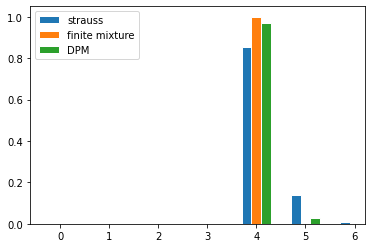

In [9]:
chains = sampler0.chains
ma_chain = np.array([len(x.a_means) for x in chains])
mna_chain = np.array([(x.mna) for x in chains])

width = 0.2
bars = np.arange(max(np.max(ma_chain), 6))
heights = np.array([np.sum(ma_chain ==i ) for i in bars])
plt.bar(bars - width, heights / len(ma_chain), width=width,
        edgecolor="white", label="strauss")

bars = np.arange(max(np.max(k_chain_raf), 5.0))
heights = np.array([np.sum(k_chain_raf ==i ) for i in bars])
plt.bar(bars, heights / len(k_chain_raf), width=width,
        edgecolor="white", label="finite mixture")

bars = np.arange(max(np.max(k_chain_bnp), 6))
heights = np.array([np.sum(k_chain_bnp == i ) for i in bars])
plt.bar(bars + width, heights / len(k_chain_bnp), width=width,
        edgecolor="white", label="DPM")

plt.legend()
# plt.savefig("images/data_0_histogram_K.pdf")
plt.show()

### DENSITY ESTIMATION

In [10]:
x_ = np.linspace(-10, 10, 100)
y_ = np.linspace(-10, 10, 100)
x, y = np.meshgrid(x_, y_)
grid = np.hstack([x.reshape(-1, 1), y.reshape(-1, 1)])

estimate = estimate_density_seq(chains, grid)
our_estimate = np.mean(estimate, axis=0)

In [11]:
bnpmix_estimate = np.loadtxt("data/data_1_dens_bnpmix.txt")

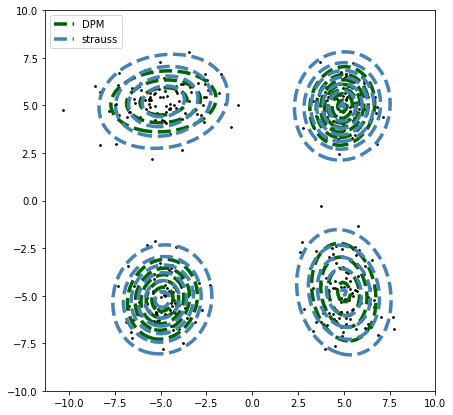

In [12]:
fig, ax = plt.subplots(figsize=(7, 7))

bnpmix_Z = griddata(grid, bnpmix_estimate, (x, y))
cntr1 = plt.contour(x, y, bnpmix_Z, colors="darkgreen", linewidths=3.5, 
            linestyles="dashed")

our_Z = griddata(grid, our_estimate, (x, y))
cntr2 = plt.contour(x, y, our_Z, colors="steelblue", linewidths=3.5, 
            linestyles="dashed")

plt.scatter(data[:, 0], data[:, 1], s=3, color="black")

h1,_ = cntr1.legend_elements()
h2,_ = cntr2.legend_elements()

ax.legend([h1[0], h2[0]], ['DPM', 'strauss'], loc="upper left")
# plt.savefig("images/data_0_dens_estimate.pdf")

plt.show()

## SIMULATION 1

In [13]:
# data = np.vstack([
#        [mvn.rvs(mean=np.array([5, 5]), cov=np.eye(2)) for _ in range(100)],
#        [mvn.rvs(mean=np.array([-5, -5]), cov=np.eye(2)) for _ in range(100)]])

# xx = np.hstack([
#         np.array([skewnorm.rvs(2, -3, 1.5) for i in range(200)]).reshape(-1, 1),
#         np.array([skewnorm.rvs(2, -3, 1.5) for i in range(200)]).reshape(-1, 1)])

# yy = np.array(
#     [mvn.rvs(mean=np.array([3, 3]), cov=np.eye(2)) for _ in range(200)])  
# data = np.vstack([xx, yy])

data = np.loadtxt("data/data_1.txt")

In [14]:
sampler = ConditionalMCMC(
    pp_params=params.strauss,
    prec_params=params.wishart,
    jump_params=params.gamma_jump,
    mala_stepsize=0.001)
sampler.run(50000, 50000, 10, data)

# sampler.serialize_chains("data/chains_sim_1.recordio")

Burnin, iter # 200  /  50000
Burnin, iter # 400  /  50000
Burnin, iter # 600  /  50000
Burnin, iter # 800  /  50000
Burnin, iter # 1000  /  50000
Burnin, iter # 1200  /  50000
Burnin, iter # 1400  /  50000
Burnin, iter # 1600  /  50000
Burnin, iter # 1800  /  50000
Burnin, iter # 2000  /  50000
Burnin, iter # 2200  /  50000
Burnin, iter # 2400  /  50000
Burnin, iter # 2600  /  50000
Burnin, iter # 2800  /  50000
Burnin, iter # 3000  /  50000
Burnin, iter # 3200  /  50000
Burnin, iter # 3400  /  50000
Burnin, iter # 3600  /  50000
Burnin, iter # 3800  /  50000
Burnin, iter # 4000  /  50000
Burnin, iter # 4200  /  50000
Burnin, iter # 4400  /  50000
Burnin, iter # 4600  /  50000
Burnin, iter # 4800  /  50000
Burnin, iter # 5000  /  50000
Burnin, iter # 5200  /  50000
Burnin, iter # 5400  /  50000
Burnin, iter # 5600  /  50000
Burnin, iter # 5800  /  50000
Burnin, iter # 6000  /  50000
Burnin, iter # 6200  /  50000
Burnin, iter # 6400  /  50000
Burnin, iter # 6600  /  50000
Burnin, iter #

Running, iter # 4000  /  50000
Running, iter # 4200  /  50000
Running, iter # 4400  /  50000
Running, iter # 4600  /  50000
Running, iter # 4800  /  50000
Running, iter # 5000  /  50000
Running, iter # 5200  /  50000
Running, iter # 5400  /  50000
Running, iter # 5600  /  50000
Running, iter # 5800  /  50000
Running, iter # 6000  /  50000
Running, iter # 6200  /  50000
Running, iter # 6400  /  50000
Running, iter # 6600  /  50000
Running, iter # 6800  /  50000
Running, iter # 7000  /  50000
Running, iter # 7200  /  50000
Running, iter # 7400  /  50000
Running, iter # 7600  /  50000
Running, iter # 7800  /  50000
Running, iter # 8000  /  50000
Running, iter # 8200  /  50000
Running, iter # 8400  /  50000
Running, iter # 8600  /  50000
Running, iter # 8800  /  50000
Running, iter # 9000  /  50000
Running, iter # 9200  /  50000
Running, iter # 9400  /  50000
Running, iter # 9600  /  50000
Running, iter # 9800  /  50000
Running, iter # 10000  /  50000
Running, iter # 10200  /  50000
Runnin

In [15]:
k_chain_raf = np.loadtxt("data/data_1_K_raf.txt")
k_chain_bnp = np.loadtxt("data/data_1_K_bnpmix.txt")

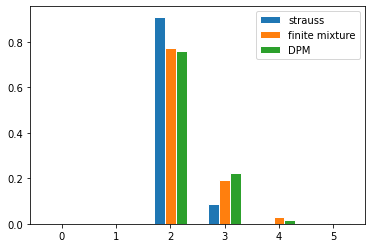

In [16]:
chains = sampler.chains
ma_chain = np.array([max(x.clus_alloc) + 1 for x in chains])
mna_chain = np.array([(x.mna) for x in chains])
np.savetxt("data/data_1_K_our.txt", ma_chain)

width = 0.2
bars = np.arange(max(np.max(ma_chain), 4))
heights = np.array([np.sum(ma_chain ==i ) for i in bars])
plt.bar(bars - width, heights / len(ma_chain), width=width,
        edgecolor="white", label="strauss")

bars = np.arange(max(np.max(k_chain_raf), 4))
heights = np.array([np.sum(k_chain_raf ==i ) for i in bars])
plt.bar(bars, heights / len(k_chain_raf), width=width,
        edgecolor="white", label="finite mixture")

bars = np.arange(max(np.max(k_chain_bnp), 4))
heights = np.array([np.sum(k_chain_bnp ==i ) for i in bars])
plt.bar(bars + width, heights / len(k_chain_bnp), width=width,
        edgecolor="white", label="DPM")


# bars = np.arange(max(np.max(mna_chain), 4))
# heights = np.array([np.sum(mna_chain ==i ) for i in bars])
# plt.bar(bars + 0.05, heights / len(mna_chain), width=0.2)

plt.legend()
# plt.savefig("images/data_1_histogram_K.pdf")
plt.show()

In [17]:
ess(ma_chain) / len(mna_chain)

0.9953466400493648

### DENSITY ESTIMATE

In [16]:
x_ = np.linspace(-6, 7, 100)
y_ = np.linspace(-6, 7, 100)
x, y = np.meshgrid(x_, y_)
grid = np.hstack([x.reshape(-1, 1), y.reshape(-1, 1)])

estimate = estimate_density_seq(chains, grid)
our_estimate = np.mean(estimate, axis=0)

In [17]:
bnpmix_estimate = np.loadtxt("data/data_1_dens_bnpmix.txt")

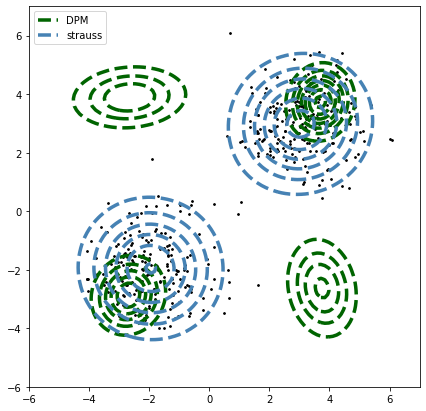

In [18]:
fig, ax = plt.subplots(figsize=(7, 7))

bnpmix_Z = griddata(grid, bnpmix_estimate, (x, y))
cntr1 = plt.contour(x, y, bnpmix_Z, colors="darkgreen", linewidths=3.5, 
            linestyles="dashed")

our_Z = griddata(grid, our_estimate, (x, y))
cntr2 = plt.contour(x, y, our_Z, colors="steelblue", linewidths=3.5, 
            linestyles="dashed")

plt.scatter(data[:, 0], data[:, 1], s=3, color="black")

h1,_ = cntr1.legend_elements()
h2,_ = cntr2.legend_elements()

ax.legend([h1[0], h2[0]], ['DPM', 'strauss'], loc="upper left")
# plt.savefig("images/data_1_dens_estimate.pdf")

plt.show()

## Univariate Like Miller and Dunson

In [19]:
from scipy.stats import dirichlet

true_mu = np.array([-3.5, 3, 0, 6])
true_sigma = np.array([0.8, 0.5, 0.4, 0.5])
w_t = np.array([0.25, 0.25, 0.3, 0.2])

alpha0 = 500
L = 10000
y_t = np.random.choice(len(w_t), size=L, replace=True, p=w_t)
locations = true_mu[y_t] + true_sigma[y_t] * np.random.normal(size=L)
weights = dirichlet.rvs(np.ones(L) * 500 / L)[0, :]
s = 0.25


def f0(x):
    out = np.zeros_like(x)
    for w, l in zip(weights, locations):
        out += w * norm.pdf(x, l, s)
    return out

def generate_data(size):
    clus_alloc = np.random.choice(L, size=size, replace=True, p=weights)
    out = np.random.normal(size=size) * s + locations[clus_alloc]
    return out

In [21]:
data = generate_data(1500)
np.savetxt("data/data_univ_miller_dunson1500.txt", data)

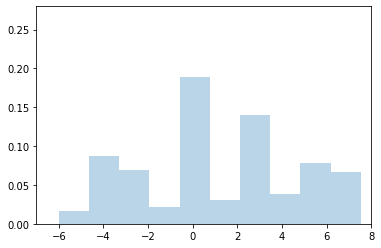

In [23]:
plt.hist(data, density=True, alpha=0.3)
plt.ylim(0, 0.28)
plt.xlim(-7, 8)
plt.savefig("images/dpcont_hist.pdf")

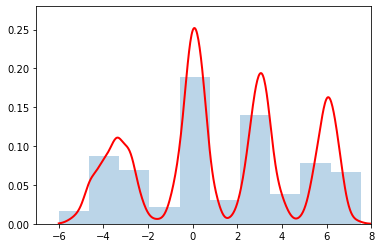

In [24]:
xgrid = np.linspace(-6, 8, 500)
f_eval = f0(xgrid)

# plt.savefig("images/data_univ_miller_dunson_true_dens.pdf")

plt.hist(data, density=True, alpha=0.3)
plt.plot(xgrid, f_eval, color="red", lw=2)

plt.ylim(0, 0.28)
plt.xlim(-7, 8)
plt.savefig("images/dpcont_hist_true.pdf")

In [45]:
kchain_py = np.loadtxt("data/dpcont1500_K_bnpmix.txt")
dens_py = np.loadtxt("data/dpcont1500_dens_bnpmix.txt")
cluschain_py = np.loadtxt("data/dpcont1500_cluschain_bnpmix.txt")

grid = np.linspace(-10, 10, 200)

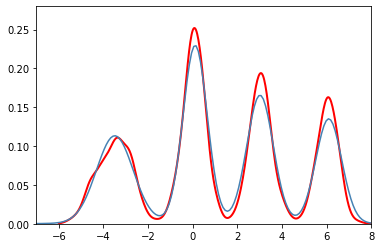

In [46]:
plt.plot(xgrid, f_eval, color="red", lw=2)
plt.plot(grid, np.mean(dens_py, axis=0), color="steelblue", lw=1.5)

plt.ylim(0, 0.28)
plt.xlim(-7, 8)
plt.savefig("images/dpcont_true_est.pdf")

In [33]:
kchain_py = kchain_py.astype(np.int)

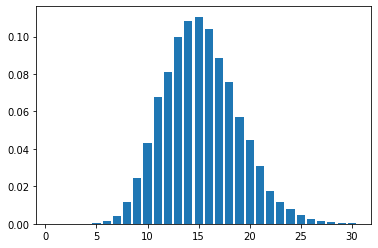

In [36]:
cnts = []
for h in range(1, np.max(kchain_py)):
    cnts.append(np.sum(kchain_py == h))

cnts = np.array(cnts)
plt.bar(range(1, np.max(kchain_py)), cnts / np.sum(cnts))
plt.savefig("images/dpcont_n_clus.pdf")

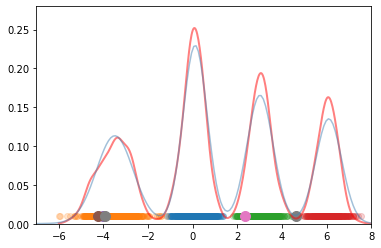

In [47]:
bestclust = np.loadtxt("data/dpcont1500_bestclus_bnpmix.txt")

plt.plot(xgrid, f_eval, color="red", lw=2, alpha=0.5)
plt.plot(grid, np.mean(dens_py, axis=0), color="steelblue", lw=1.5, alpha=0.5)


for h in [1, 2, 4, 5]:
    dataclus = data[bestclust == h]
    plt.scatter(dataclus, np.zeros(len(dataclus)) + 0.01, alpha=0.2)

    
for h in [3, 6, 7, 8]:
    dataclus = data[bestclust == h]
    plt.scatter(dataclus, np.zeros(len(dataclus)) + 0.01, s=100)

plt.ylim(0, 0.28)
plt.xlim(-7, 8)

plt.savefig("images/dpcont_best_clust.pdf")

In [21]:
# import pickle
# with open("data/data_univ_miller_dunson_true_f.pickle", 'wb') as fp:
#     pickle.dump({"xgrid": xgrid, "f_eval": f0(xgrid)}, fp)

In [22]:
# np.savetxt("data/data_univ_miller_dunson.txt", data)

(array([ 22.,  62.,  23.,  33., 131.,  15.,  87.,  19.,  68.,  40.]),
 array([-5.62265426, -4.31200308, -3.0013519 , -1.69070072, -0.38004955,
         0.93060163,  2.24125281,  3.55190399,  4.86255517,  6.17320635,
         7.48385753]),
 <a list of 10 Patch objects>)

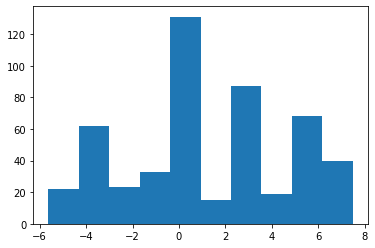

In [28]:
data = np.loadtxt("data/data_univ_miller_dunson.txt")
plt.hist(data)

In [30]:
strauss_params = make_default_strauss(data.reshape(-1, 1))
strauss_params

prior {
  beta_l: 0.038148975704167594
  beta_u: 4.577877084500111
}
init {
  beta: 0.038148975704167594
  gamma: 4.5399929762484854e-05
  R: 1.6465467078031315
}

In [31]:
strauss_params = make_default_strauss(data.reshape(-1, 1))
# nrep_params = params_pb2.NrepParams(u=0.5, p=0.9)
gamma_prec_params = params_pb2.GammaParams(alpha=1, beta=1)
gamma_jump_params = params_pb2.GammaParams(alpha=1, beta=1)

strauss_params.init.gamma = 1e-10
strauss_params.init.beta = 0.0000001
strauss_params.fixed_params = True

sampler = ConditionalMCMC(pp_params=strauss_params, 
                          prec_params=gamma_prec_params,
                          jump_params=gamma_prec_params, mala_stepsize=0.0001)


sampler.run(10000, 10000, 10, data)

Burnin, iter # 200  /  10000
Burnin, iter # 400  /  10000
Burnin, iter # 600  /  10000
Burnin, iter # 800  /  10000
Burnin, iter # 1000  /  10000
Burnin, iter # 1200  /  10000
Burnin, iter # 1400  /  10000
Burnin, iter # 1600  /  10000
Burnin, iter # 1800  /  10000
Burnin, iter # 2000  /  10000
Burnin, iter # 2200  /  10000
Burnin, iter # 2400  /  10000
Burnin, iter # 2600  /  10000
Burnin, iter # 2800  /  10000
Burnin, iter # 3000  /  10000
Burnin, iter # 3200  /  10000
Burnin, iter # 3400  /  10000
Burnin, iter # 3600  /  10000
Burnin, iter # 3800  /  10000
Burnin, iter # 4000  /  10000
Burnin, iter # 4200  /  10000
Burnin, iter # 4400  /  10000
Burnin, iter # 4600  /  10000
Burnin, iter # 4800  /  10000
Burnin, iter # 5000  /  10000
Burnin, iter # 5200  /  10000
Burnin, iter # 5400  /  10000
Burnin, iter # 5600  /  10000
Burnin, iter # 5800  /  10000
Burnin, iter # 6000  /  10000
Burnin, iter # 6200  /  10000
Burnin, iter # 6400  /  10000
Burnin, iter # 6600  /  10000
Burnin, iter #

In [ ]:
# sampler.serialize_chains("data/data_univ_miller_dunson_chains.recordio")

In [32]:
from scipy.stats import norm
import seaborn as sns

xgrid = np.linspace(-6, 8, 500)
dens = estimate_density_seq(sampler.chains, xgrid)

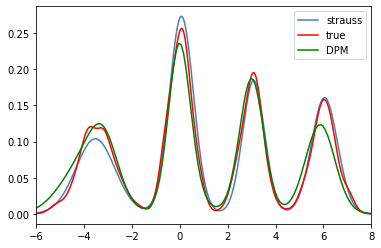

In [34]:
bnpmix_estimate = np.loadtxt("data/data_univ_miller_dunson_dens_bnpmix.txt")
plt.plot(xgrid, np.mean(dens, axis=0), color="steelblue", label="strauss")
plt.plot(xgrid, f_eval, color="red", label="true")
plt.plot(np.linspace(-10, 10, 200), np.mean(bnpmix_estimate, axis=0), color="green", label="DPM")
plt.xlim(-6, 8)
plt.legend()
# plt.savefig("images/data_univ_miller_dunson_dens_estimate.pdf")

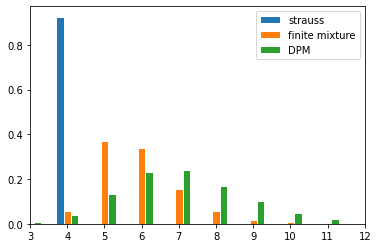

In [35]:
k_chain_raf = np.loadtxt("data/data_univ_miller_dunson_K_raf.txt")
k_chain_bnp = np.loadtxt("data/data_univ_miller_dunson_K_bnpmix.txt")


chains = sampler.chains[200:]
ma_chain = np.array([max(x.clus_alloc) + 1 for x in chains])
mna_chain = np.array([(x.mna) for x in chains])
np.savetxt("data/data_1_K_our.txt", ma_chain)

width = 0.2
bars = np.arange(max(np.max(ma_chain), 4))
heights = np.array([np.sum(ma_chain ==i ) for i in bars])
plt.bar(bars - width, heights / len(ma_chain), width=width,
        edgecolor="white", label="strauss")

bars = np.arange(max(np.max(k_chain_raf), 4))
heights = np.array([np.sum(k_chain_raf ==i ) for i in bars])
plt.bar(bars, heights / len(k_chain_raf), width=width,
        edgecolor="white", label="finite mixture")

bars = np.arange(max(np.max(k_chain_bnp), 4))
heights = np.array([np.sum(k_chain_bnp ==i ) for i in bars])
plt.bar(bars + width, heights / len(k_chain_bnp), width=width,
        edgecolor="white", label="DPM")

plt.xlim((3, 12))

plt.legend()
# plt.savefig("images/data_miller_dunson_hist_k.pdf")
plt.show()

# Univariate of T and SkewNormal

(array([ 5., 37., 45., 11.,  2.,  0.,  0.,  0., 61., 39.]),
 array([-8.59069161, -6.99350519, -5.39631877, -3.79913235, -2.20194593,
        -0.60475951,  0.99242691,  2.58961333,  4.18679975,  5.78398618,
         7.3811726 ]),
 <a list of 10 Patch objects>)

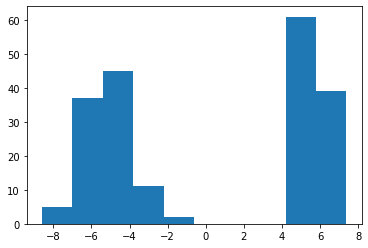

In [36]:
from scipy.stats import t, cauchy, skewnorm
data = np.concatenate([
        [t.rvs(5, loc=-5) for _ in range(100)],
        [skewnorm.rvs(2, loc=5) for _ in range(100)]])

plt.hist(data)

In [37]:
# np.savetxt("data/data_univ_1.txt", data)
data = np.loadtxt("data/data_univ_1.txt")

In [45]:
strauss_params = make_default_strauss(data.reshape(-1, 1))
gamma_prec_params = params_pb2.GammaParams(alpha=2, beta=2)
gamma_jump_params = params_pb2.GammaParams(alpha=1, beta=100)

strauss_params.init.gamma = 1e-30
strauss_params.init.beta = 1e-500
strauss_params.init.R = 5.0
strauss_params.fixed_params = True


sampler = ConditionalMCMC(pp_params=strauss_params, 
                          prec_params=gamma_prec_params,
                          jump_params=gamma_prec_params,
                          mala_stepsize=0.001)


sampler.run(10000, 10000, 1, data)

Burnin, iter # 200  /  10000
Burnin, iter # 400  /  10000
Burnin, iter # 600  /  10000
Burnin, iter # 800  /  10000
Burnin, iter # 1000  /  10000
Burnin, iter # 1200  /  10000
Burnin, iter # 1400  /  10000
Burnin, iter # 1600  /  10000
Burnin, iter # 1800  /  10000
Burnin, iter # 2000  /  10000
Burnin, iter # 2200  /  10000
Burnin, iter # 2400  /  10000
Burnin, iter # 2600  /  10000
Burnin, iter # 2800  /  10000
Burnin, iter # 3000  /  10000
Burnin, iter # 3200  /  10000
Burnin, iter # 3400  /  10000
Burnin, iter # 3600  /  10000
Burnin, iter # 3800  /  10000
Burnin, iter # 4000  /  10000
Burnin, iter # 4200  /  10000
Burnin, iter # 4400  /  10000
Burnin, iter # 4600  /  10000
Burnin, iter # 4800  /  10000
Burnin, iter # 5000  /  10000
Burnin, iter # 5200  /  10000
Burnin, iter # 5400  /  10000
Burnin, iter # 5600  /  10000
Burnin, iter # 5800  /  10000
Burnin, iter # 6000  /  10000
Burnin, iter # 6200  /  10000
Burnin, iter # 6400  /  10000
Burnin, iter # 6600  /  10000
Burnin, iter #

In [46]:
# sampler.serialize_chains("data/data_1_chains.recordio")

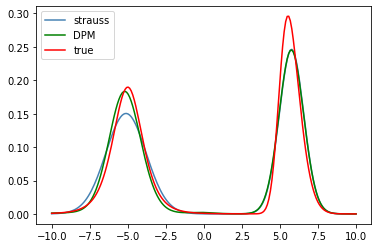

In [47]:
grid = np.linspace(-10, 10, 200)
dens = estimate_density_seq(sampler.chains, grid)

bnpmix_estimate = np.loadtxt("data/data_1_univ_dens_bnpmix.txt")

plt.plot(grid, np.mean(dens, axis=0), label="strauss", color="steelblue")
plt.plot(grid, np.mean(bnpmix_estimate, axis=0), label="DPM", color="green")
plt.plot(grid, 0.5*t.pdf(grid, 5, loc=-5) + 0.5*skewnorm.pdf(grid, 2, loc=5), label="true", color="red")
plt.legend()

# plt.savefig("images/data_univ_1_dens_estimate.pdf")
plt.show()

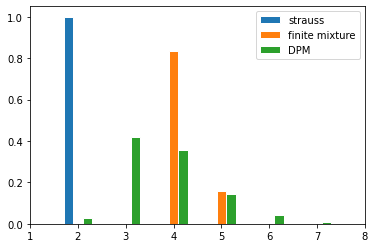

In [48]:
k_chain_raf = np.loadtxt("data/data_univ_1_K_raf.txt")
k_chain_bnp = np.loadtxt("data/data_1_univ_K_bnpmix.txt")


chains = sampler.chains
ma_chain = np.array([max(x.clus_alloc) + 1 for x in chains])
mna_chain = np.array([(x.mna) for x in chains])
# np.savetxt("data/data_1_K_our.txt", ma_chain)

width = 0.2
bars = np.arange(max(np.max(ma_chain), 4))
heights = np.array([np.sum(ma_chain ==i ) for i in bars])
plt.bar(bars - width, heights / len(ma_chain), width=width,
        edgecolor="white", label="strauss")

bars = np.arange(max(np.max(k_chain_raf), 4))
heights = np.array([np.sum(k_chain_raf ==i ) for i in bars])
plt.bar(bars, heights / len(k_chain_raf), width=width,
        edgecolor="white", label="finite mixture")

bars = np.arange(max(np.max(k_chain_bnp), 4))
heights = np.array([np.sum(k_chain_bnp ==i ) for i in bars])
plt.bar(bars + width, heights / len(k_chain_bnp), width=width,
        edgecolor="white", label="DPM")

plt.xlim((1, 8))

plt.legend()
# plt.savefig("images/data_univ_1_histogram_K.pdf")
plt.show()